In [1]:
import os
import warnings

import hopsworks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')
HOPSWORKS_AVAILABLE = True

c:\Users\Zuhair\Programming Projects\Python\10P_AQI_Predictor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CONFIG
HOPSWORKS_PROJECT_NAME = "jurjanji_AQI"
load_dotenv()
HOPSWORKS_API_KEY = os.getenv("hopsworks_api_key")
FEATURE_GROUP_NAME = 'air_quality_data'
FEATURE_GROUP_VERSION = 1

# Utility: show a pretty dataframe head
def show(df, n=5):
    display(df.head(n))

In [3]:
# 1) LOAD DATA - try Hopsworks Feature Store first, else fallback to local CSV
if HOPSWORKS_AVAILABLE and (HOPSWORKS_API_KEY is not None or HOPSWORKS_PROJECT_NAME is not None):
    print('Attempting to load from Hopsworks Feature Store...')
    project = hopsworks.login(api_key_value=HOPSWORKS_API_KEY, project=HOPSWORKS_PROJECT_NAME)
    fs = project.get_feature_store()
    try:
        fg = fs.get_feature_group(name=FEATURE_GROUP_NAME, version=FEATURE_GROUP_VERSION)
        df = fg.read()
        print('Loaded from Hopsworks:', df.shape)
    except Exception as e:
        print('Could not read feature group from Hopsworks:', e)
else:
    print('Hopsworks not available or API key/project not set')

Attempting to load from Hopsworks Feature Store...
2025-11-08 21:18:24,085 INFO: Initializing external client
2025-11-08 21:18:24,087 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-08 21:18:26,718 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1251480
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (8.24s) 
Loaded from Hopsworks: (28581, 101)


In [4]:
# Ensure timestamp column exists and is datetime
if 'timestamp_utc' in df.columns:
    df['timestamp_utc'] = pd.to_datetime(df['timestamp_utc'])
    df = df.sort_values('timestamp_utc').reset_index(drop=True)
else:
    raise ValueError('No timestamp column found. Ensure dataset includes a timestamp column.')

print('Data shape:', df.shape)

Data shape: (28581, 101)


In [5]:
df.info()
df.describe().T.head(10)
df.isna().sum().sort_values(ascending=False).head(25)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28581 entries, 0 to 28580
Columns: 101 entries, timestamp_utc to timestamp_key
dtypes: datetime64[us, Etc/UTC](1), float64(94), int32(4), object(2)
memory usage: 21.6+ MB


aqi_delta_24h                 384
aqi_pct_change_24h            384
aqi_delta_3h                  362
aqi_pct_change_3h             362
wind_gust_rolling_avg_30d     360
wind_gust                     360
wind_gust_rolling_avg_24h     360
wind_gust_rolling_avg_7d      360
wind_gust_rolling_avg_4h      360
humidity_rolling_avg_24h        0
humidity_rolling_avg_7d         0
nh3_rolling_avg_30d             0
temp_rolling_avg_4h             0
wind_deg_rolling_avg_24h        0
temp_rolling_avg_24h            0
temp_rolling_avg_7d             0
temp_rolling_avg_30d            0
humidity_rolling_avg_4h         0
wind_deg_rolling_avg_4h         0
wind_speed_rolling_avg_30d      0
wind_speed_rolling_avg_7d       0
wind_speed_rolling_avg_24h      0
wind_speed_rolling_avg_4h       0
pressure_rolling_avg_30d        0
wind_deg_rolling_avg_7d         0
dtype: int64

In [6]:
# QUICK OVERVIEW
print('Columns:')
print(df.columns.tolist())
print('\nBasic info:')
print(df.info())

# Summary stats
display(df.describe(include='all').T)

Columns:
['timestamp_utc', 'city', 'temp', 'temp_feels_like', 'humidity', 'pressure', 'wind_speed', 'wind_deg', 'wind_gust', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3', 'ow_aqi_index', 'hour', 'day_of_week', 'day_of_month', 'month', 'co_rolling_avg_4h', 'co_rolling_avg_24h', 'co_rolling_avg_7d', 'co_rolling_avg_30d', 'no_rolling_avg_4h', 'no_rolling_avg_24h', 'no_rolling_avg_7d', 'no_rolling_avg_30d', 'no2_rolling_avg_4h', 'no2_rolling_avg_24h', 'no2_rolling_avg_7d', 'no2_rolling_avg_30d', 'o3_rolling_avg_4h', 'o3_rolling_avg_24h', 'o3_rolling_avg_7d', 'o3_rolling_avg_30d', 'so2_rolling_avg_4h', 'so2_rolling_avg_24h', 'so2_rolling_avg_7d', 'so2_rolling_avg_30d', 'pm2_5_rolling_avg_4h', 'pm2_5_rolling_avg_24h', 'pm2_5_rolling_avg_7d', 'pm2_5_rolling_avg_30d', 'pm10_rolling_avg_4h', 'pm10_rolling_avg_24h', 'pm10_rolling_avg_7d', 'pm10_rolling_avg_30d', 'nh3_rolling_avg_4h', 'nh3_rolling_avg_24h', 'nh3_rolling_avg_7d', 'nh3_rolling_avg_30d', 'temp_rolling_avg_4h', 'temp_rollin

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
timestamp_utc,28581,NaN,NaN,NaN,2023-04-24 06:59:19.106210+00:00,2021-08-24 00:00:00+00:00,2022-06-19 17:00:00+00:00,2023-04-21 10:00:00+00:00,2024-02-17 05:00:00+00:00,2025-11-08 16:15:10.486063+00:00,NaN
city,28581,1,Karachi,28581,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temp,28581.0,NaN,NaN,NaN,29.770382,8.9,23.8,27.2,29.6,311.05,31.005595
temp_feels_like,28581.0,NaN,NaN,NaN,31.593555,3.0,24.4,30.2,32.9,308.25,31.012211
humidity,28581.0,NaN,NaN,NaN,68.964802,5.0,57.0,74.0,85.0,100.0,20.647044
...,...,...,...,...,...,...,...,...,...,...,...
day_of_week_sin,28581.0,NaN,NaN,NaN,0.003308,-0.974928,-0.781831,0.0,0.781831,0.974928,0.706883
day_of_week_cos,28581.0,NaN,NaN,NaN,-0.005029,-0.900969,-0.900969,-0.222521,0.62349,1.0,0.70733
month_sin,28581.0,NaN,NaN,NaN,-0.07937,-1.0,-0.866025,-0.0,0.5,1.0,0.71262
month_cos,28581.0,NaN,NaN,NaN,0.037264,-1.0,-0.5,0.0,0.866025,1.0,0.696074


In [7]:
# # MISSINGNESS ANALYSIS
# missing = df.isnull().mean().sort_values(ascending=False)
# print('Missing fraction per column:')
# print(missing[missing>0])


# # Visual missingness (simple)
# plt.figure(figsize=(12,4))
# sns.heatmap(df.isnull().T, cbar=False)
# plt.title('Missingness map (columns x rows)')
# plt.savefig("missingness_map(columns_x_rows).png")
# plt.show()

In [8]:
# # DISTRIBUTIONS - numeric cols
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric columns:', numeric_cols)


# plt.figure(figsize=(14, 6))
# for i, col in enumerate(numeric_cols):
#     plt.subplot(2, int(np.ceil(len(numeric_cols)/2)), i+1)
#     sns.histplot(df[col].dropna(), kde=True)
#     plt.title(col)
#     plt.tight_layout()
#     plt.show()
#     plt.savefig("numeric_cols_distribution.png")

Numeric columns: ['temp', 'temp_feels_like', 'humidity', 'pressure', 'wind_speed', 'wind_deg', 'wind_gust', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3', 'ow_aqi_index', 'hour', 'day_of_week', 'day_of_month', 'month', 'co_rolling_avg_4h', 'co_rolling_avg_24h', 'co_rolling_avg_7d', 'co_rolling_avg_30d', 'no_rolling_avg_4h', 'no_rolling_avg_24h', 'no_rolling_avg_7d', 'no_rolling_avg_30d', 'no2_rolling_avg_4h', 'no2_rolling_avg_24h', 'no2_rolling_avg_7d', 'no2_rolling_avg_30d', 'o3_rolling_avg_4h', 'o3_rolling_avg_24h', 'o3_rolling_avg_7d', 'o3_rolling_avg_30d', 'so2_rolling_avg_4h', 'so2_rolling_avg_24h', 'so2_rolling_avg_7d', 'so2_rolling_avg_30d', 'pm2_5_rolling_avg_4h', 'pm2_5_rolling_avg_24h', 'pm2_5_rolling_avg_7d', 'pm2_5_rolling_avg_30d', 'pm10_rolling_avg_4h', 'pm10_rolling_avg_24h', 'pm10_rolling_avg_7d', 'pm10_rolling_avg_30d', 'nh3_rolling_avg_4h', 'nh3_rolling_avg_24h', 'nh3_rolling_avg_7d', 'nh3_rolling_avg_30d', 'temp_rolling_avg_4h', 'temp_rolling_avg_24h', 'temp

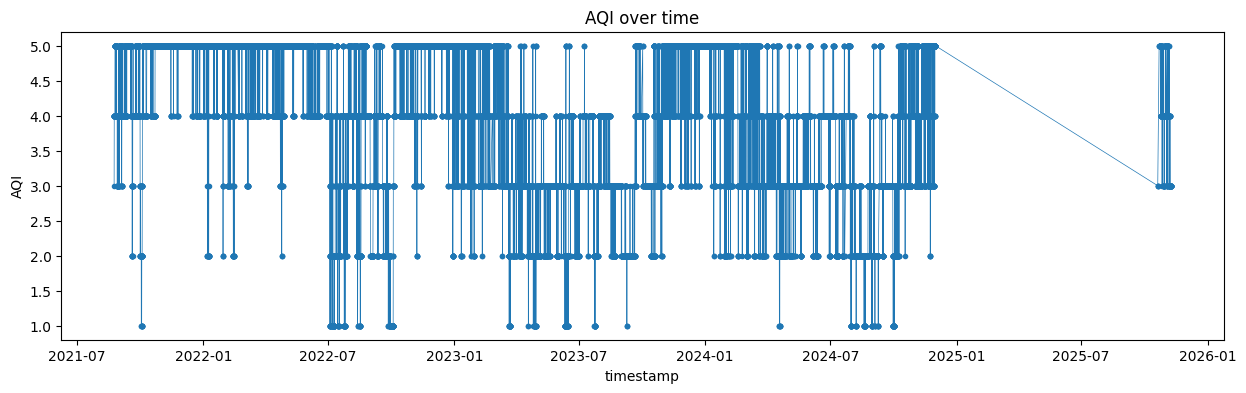

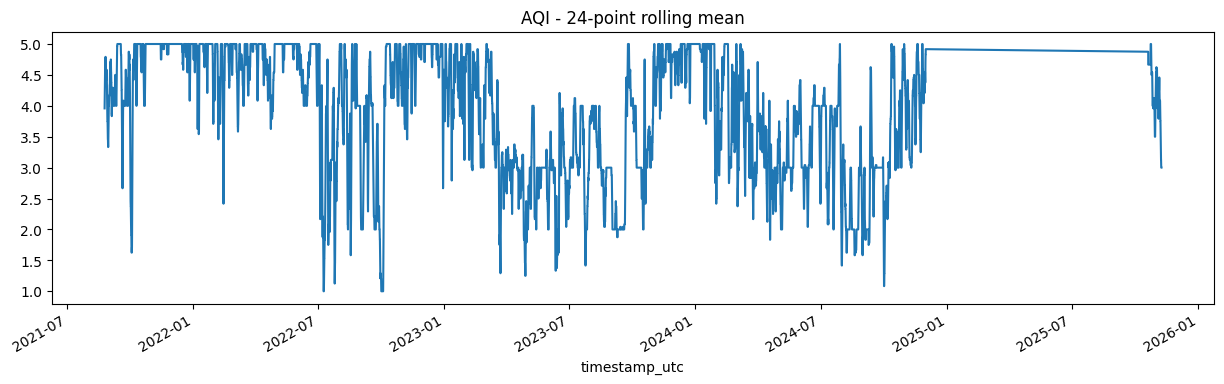

In [9]:
# TIME SERIES PLOTS - AQI over time
if 'ow_aqi_index' in df.columns:
    plt.figure(figsize=(15,4))
    plt.plot(df['timestamp_utc'], df['ow_aqi_index'], marker='.', linewidth=0.5)
    plt.title('AQI over time')
    plt.xlabel('timestamp')
    plt.ylabel('AQI')
    plt.savefig("aqi_over_time.png")
    plt.show()
    
    # Rolling averages
    plt.figure(figsize=(15,4))
    df.set_index('timestamp_utc')['ow_aqi_index'].rolling(window=24).mean().plot()
    plt.title('AQI - 24-point rolling mean')
    plt.savefig("aqi_rolling_avgs.png")
    plt.show()  
else:
    print('AQI column not found - skip AQI time plots')

In [10]:
# # SEASONAL DECOMPOSITION (daily/weekly) - requires regular frequency
# # We attempt to set the series to hourly frequency if possible
# try:
#     ts = df.set_index('timestamp_utc')['ow_aqi_index'].asfreq('H')
#     ts_interpolated = ts.interpolate()
#     decomposition = seasonal_decompose(ts_interpolated, model='additive', period=24) # daily
#     fig = decomposition.plot()
#     fig.set_size_inches(12, 8)
#     plt.suptitle('Seasonal Decompose (period=24)')
#     plt.savefig("seasonal_decomposition.png")
#     plt.show()   
# except Exception as e:
#     print('Seasonal decomposition failed:', e)

In [11]:
# # CORRELATION HEATMAP (pollutants vs AQI)
# plt.figure(figsize=(10,8))
# corr = df[numeric_cols].corr()
# sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
# plt.title('Correlation matrix')
# plt.savefig("correlation_heatmap_vsAQI.png")
# plt.show()

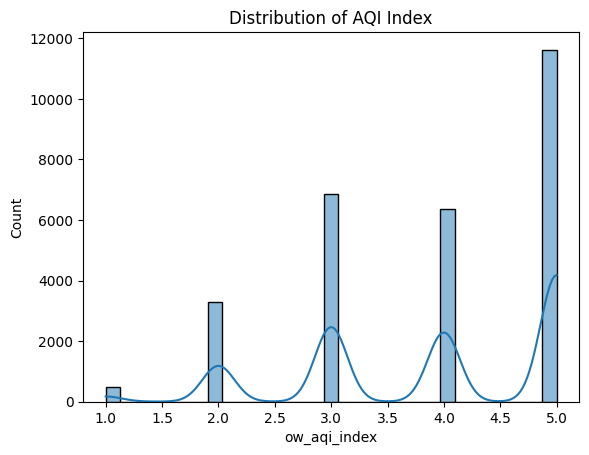

In [12]:
# the target label distribution
# checking is AQI target values are balanced or spread about
sns.histplot(df['ow_aqi_index'], kde=True) # type: ignore
plt.title("Distribution of AQI Index")
plt.savefig("aqi_distribution.png")
plt.show()

In [13]:
# # Focused scatter plots vs AQI
# if 'ow_aqi_index' in df.columns:
#     pollutants = [c for c in numeric_cols if c != 'ow_aqi_index' and c.lower() not in ['index']]
#     plt.figure(figsize=(14, 4*len(pollutants)))
#     for i, col in enumerate(pollutants):
#         plt.subplot(len(pollutants), 1, i+1)
#         plt.scatter(df[col], df['ow_aqi_index'], alpha=0.3, s=8)
#         plt.xlabel(col)
#         plt.ylabel('AQI')
#         plt.title(f'AQI vs {col}')
#         plt.tight_layout()
#     plt.savefig("aqi_vs_pollutants.png")
#     plt.show()

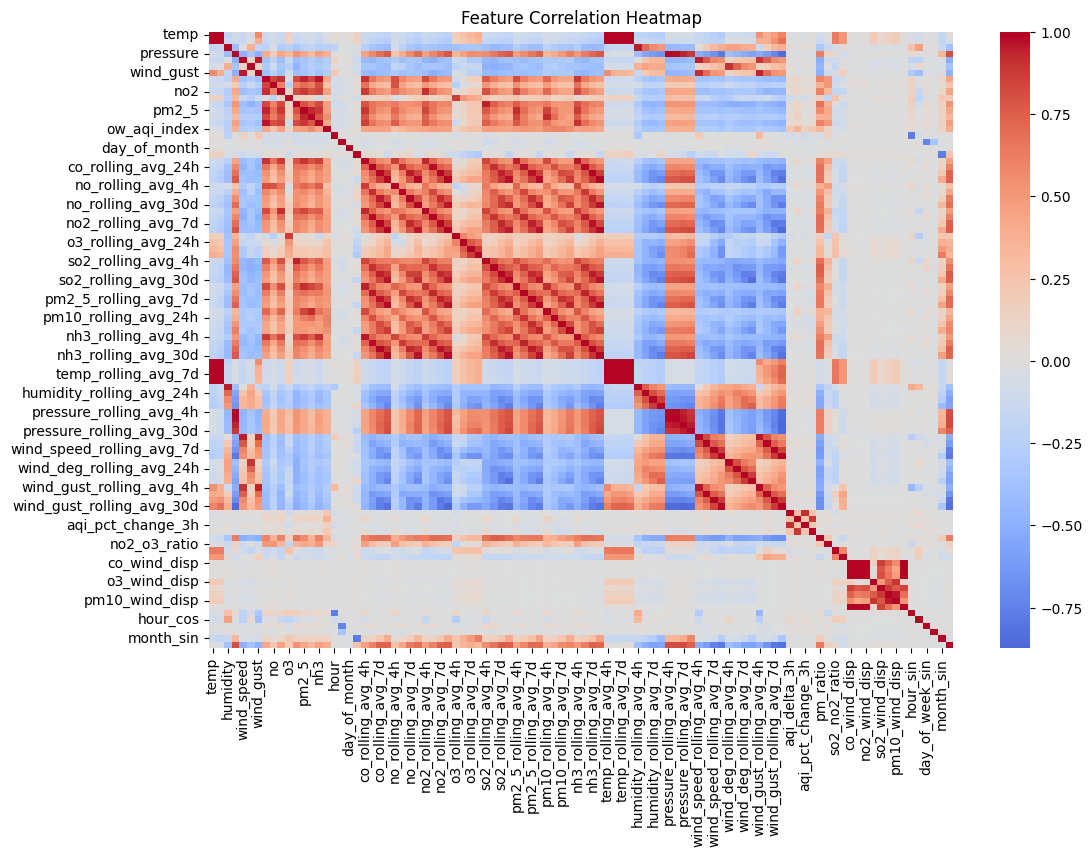

In [14]:
# checking which features have the strongest correlation with the target label
corr = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Heatmap")
plt.savefig("correlation_heatmap.png")
plt.show()


# the top 10 correlated features
# Top correlated with AQI
corr['ow_aqi_index'].sort_values(ascending=False).head(10)
corr['ow_aqi_index'].sort_values(ascending=False).to_csv("feature_correlations.csv")

In [15]:
# # identifying trends over time
# df['timestamp_utc'] = pd.to_datetime(df['timestamp_utc'])
# plt.figure(figsize=(10, 5))
# plt.plot(df['timestamp_utc'], df['ow_aqi_index'], marker='o')
# plt.title("AQI Over Time")
# plt.xlabel("Date")
# plt.ylabel("AQI")
# plt.xticks(rotation=45)
# plt.savefig("aqi_over_time_2.png")
# plt.show()

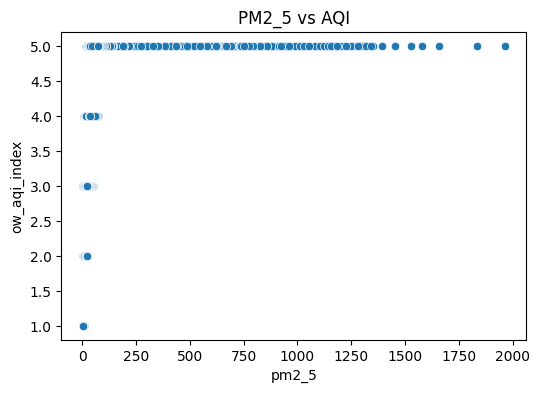

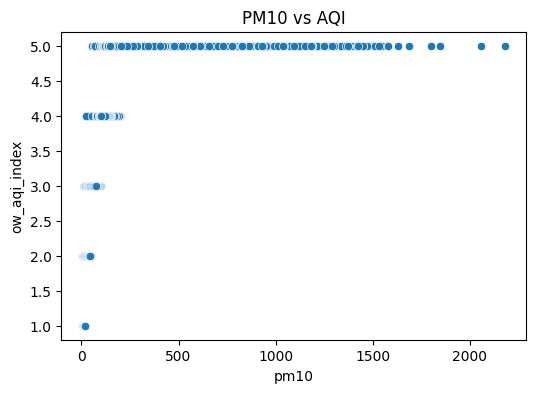

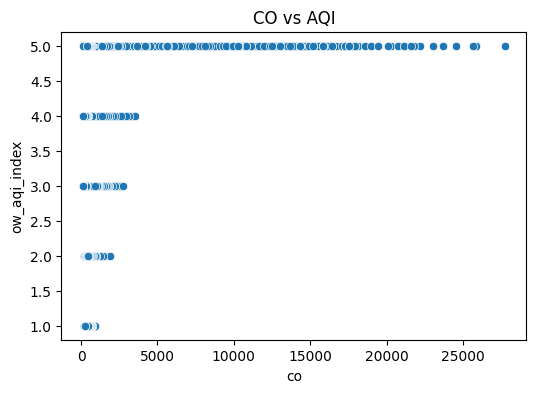

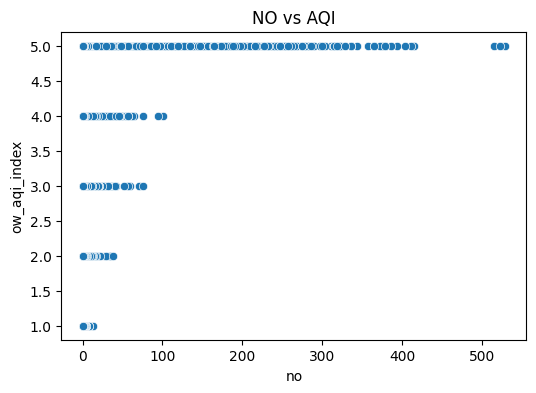

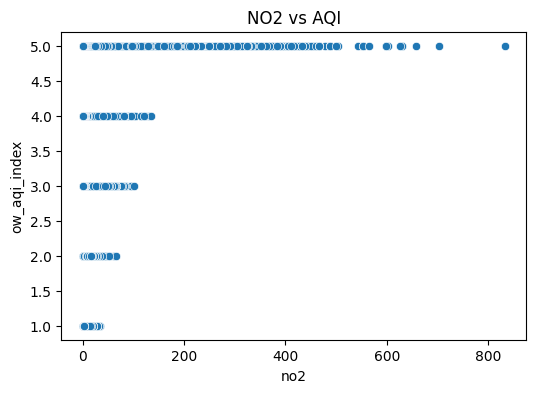

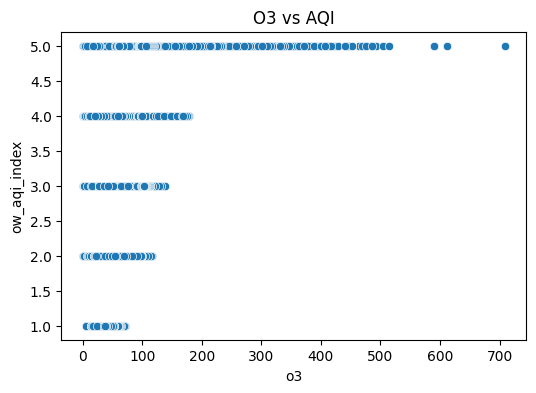

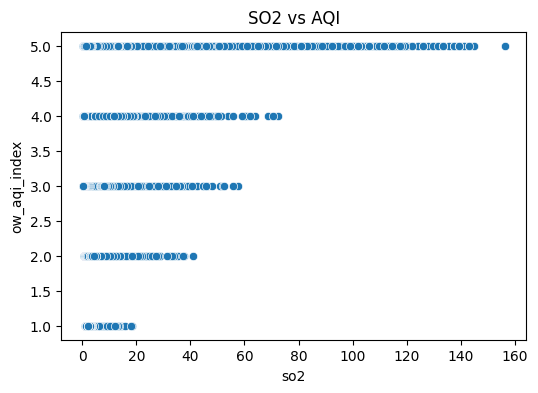

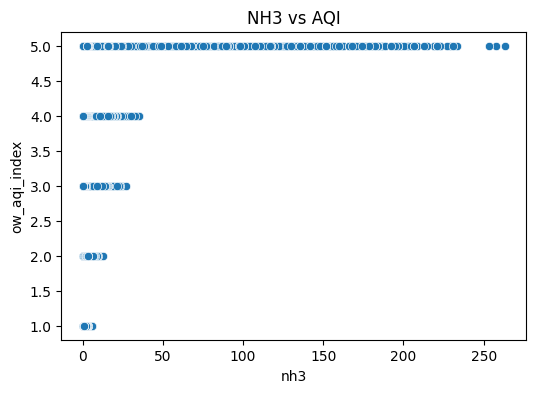

In [16]:
# seeing how the pollutants relate to the AQI
pollutants = ['pm2_5', 'pm10', 'co', 'no', 'no2', 'o3', 'so2', 'nh3']
for col in pollutants:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x=col, y='ow_aqi_index')
    plt.title(f"{col.upper()} vs AQI")
    plt.savefig(f"pollutants_correlation/{col}_vs_aqi.png")
    plt.show()

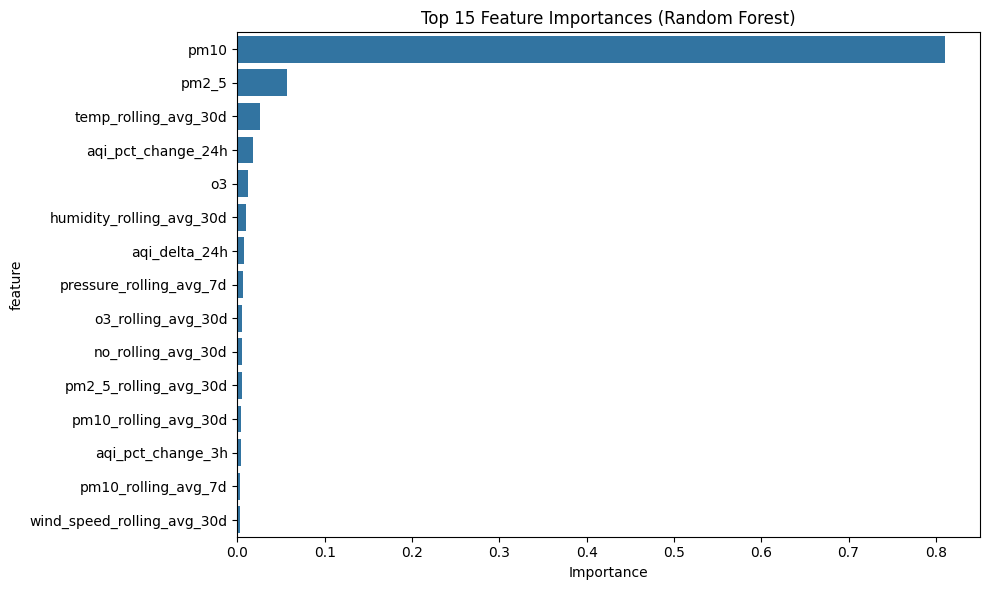


Top Features:
                       feature  importance
13                        pm10    0.810078
12                       pm2_5    0.056451
54        temp_rolling_avg_30d    0.025792
78          aqi_pct_change_24h    0.018059
10                          o3    0.011851
58    humidity_rolling_avg_30d    0.009852
76               aqi_delta_24h    0.007120
61     pressure_rolling_avg_7d    0.006568
34          o3_rolling_avg_30d    0.005764
26          no_rolling_avg_30d    0.005602
42       pm2_5_rolling_avg_30d    0.005281
46        pm10_rolling_avg_30d    0.004524
77           aqi_pct_change_3h    0.004026
45         pm10_rolling_avg_7d    0.003368
66  wind_speed_rolling_avg_30d    0.003226


In [17]:

# Prepare data (drop nulls for quick check)
feature_cols = [c for c in numeric_cols if c != 'ow_aqi_index' and 'lag' not in c]
X = df[feature_cols].fillna(df[feature_cols].median())
y = df['ow_aqi_index']

# Quick RF model
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Plot feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

print("\nTop Features:")
print(importance_df)

In [18]:
# SHAP Analysis (still saves inside temp dir)
from shap_analysis import generate_shap_analysis

# X = df.drop(columns=["ow_aqi_index", "timestamp_utc", "city"])
generate_shap_analysis(rf, X)

Generating SHAP explainability plots...


100%|===================| 28512/28581 [07:51<00:01]        